In [ ]:
#imports

import pandas as pd 
import tensorflow as tf

from keras.models import Sequential
from keras.optimizers import Adam,RMSprop
from keras.layers import Conv1D, ZeroPadding2D, Activation, Input, concatenate,Dropout
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling1D
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.optimizers import *
from keras.engine.topology import Layer
from keras import backend as K
from keras.regularizers import l2

In [ ]:
df_train=pd.read_csv('/content/drive/MyDrive/Intrusion Detection/KDDTrain+.txt')
df_test = pd.read_csv('/content/drive/MyDrive/Intrusion Detection/KDDTest+.txt')

In [ ]:
# add the column labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df_train.columns = columns
df_test.columns = columns


In [ ]:
df = df_train
df_ = df_test

In [ ]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125968,8,udp,private,SF,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125969,0,tcp,smtp,SF,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125970,0,tcp,klogin,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.0,1.0,0.0,0.0,0.06,0.05,0.00,255,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


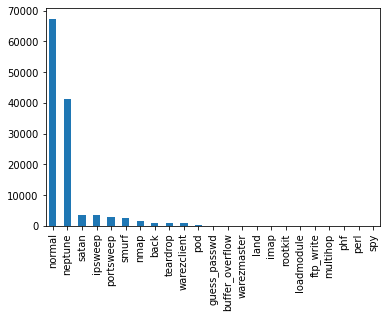

In [ ]:
df['attack'].value_counts().plot(kind='bar');

In [ ]:
df.describe

<bound method NDFrame.describe of         duration protocol_type  ...   attack level
0              0           udp  ...   normal    15
1              0           tcp  ...  neptune    19
2              0           tcp  ...   normal    21
3              0           tcp  ...   normal    21
4              0           tcp  ...  neptune    21
...          ...           ...  ...      ...   ...
125967         0           tcp  ...  neptune    20
125968         8           udp  ...   normal    21
125969         0           tcp  ...   normal    18
125970         0           tcp  ...  neptune    20
125971         0           tcp  ...   normal    21

[125972 rows x 43 columns]>

In [ ]:
df["attack"] = df["attack"].replace(['back','land','pod','smurf','teardrop','neptune','mailbomb','processtable','udpstorm','apache2','worm'],"DOS")
df["attack"] = df["attack"].replace(['ipsweep','satan','nmap','portsweep','mscan','saint'],"Probe")
df["attack"] = df["attack"].replace(['warezclient','imap','spy','multihop','guess_passwd', 'ftp_write','warezmaster', 'phf','xlock','xsnoop','snmpguess','snmpgetattack','httptunnel','sendmail','named'],"R2L")
df["attack"] = df["attack"].replace(['perl','rootkit','buffer_overflow','loadmodule','sqlattack','xterm','ps'],"U2R")
df["attack"] = df["attack"].replace(['normal'],"Normal")

In [ ]:
df_["attack"] = df_["attack"].replace(['back','land','pod','smurf','teardrop','neptune','mailbomb','processtable','udpstorm','apache2','worm'],"DOS")
df_["attack"] = df_["attack"].replace(['ipsweep','satan','nmap','portsweep','mscan','saint'],"Probe")
df_["attack"] = df_["attack"].replace(['warezclient','imap','spy','multihop','guess_passwd', 'ftp_write','warezmaster', 'phf','xlock','xsnoop','snmpguess','snmpgetattack','httptunnel','sendmail','named'],"R2L")
df_["attack"] = df_["attack"].replace(['perl','rootkit','buffer_overflow','loadmodule','sqlattack','xterm','ps'],"U2R")
df_["attack"] = df_["attack"].replace(['normal'],"Normal")

In [ ]:
Y_train = df['attack']
Y_test = df_['attack']

In [ ]:
Y_train = pd.get_dummies(Y_train)
Y_test = pd.get_dummies(Y_test)

In [ ]:
#Drop the attack label from input

X_train = df.drop(labels=['attack','level'],axis=1)
X_test = df_.drop(labels=['attack','level'],axis=1)

In [ ]:
X_train.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00
5,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,166,9,1.0,1.0,0.0,0.0,0.05,0.06,0.00,255,9,0.04,0.05,0.00,0.00,1.00,1.00,0.0,0.00
6,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117,16,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,15,0.06,0.07,0.00,0.00,1.00,1.00,0.0,0.00
7,0,tcp,remote_job,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,270,23,1.0,1.0,0.0,0.0,0.09,0.05,0.00,255,23,0.09,0.05,0.00,0.00,1.00,1.00,0.0,0.00
8,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,8,1.0,1.0,0.0,0.0,0.06,0.06,0.00,255,13,0.05,0.06,0.00,0.00,1.00,1.00,0.0,0.00
9,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,205,12,0.0,0.0,1.0,1.0,0.06,0.06,0.00,255,12,0.05,0.07,0.00,0.00,0.00,0.00,1.0,1.00


In [ ]:
X_train['protocol_type'].value_counts()

tcp     102688
udp      14993
icmp      8291
Name: protocol_type, dtype: int64

In [ ]:
X_train = pd.get_dummies(X_train, columns=['protocol_type','service','flag'])
X_test = pd.get_dummies(X_test,columns=['protocol_type','service','flag'])

In [ ]:
print("in train but not in test\n")
for i in X_train.columns:
  if i not in X_test.columns:
    print(i)
print("\n\nin test but not in train")
for i in X_test.columns:
  if i not in X_train.columns:
    print(i)

in train but not in test

service_aol
service_harvest
service_http_2784
service_http_8001
service_red_i
service_urh_i


in test but not in train


In [ ]:
X_train = X_train.drop(labels=['service_aol','service_harvest','service_http_2784','service_http_8001','service_red_i','service_urh_i'],axis=1)

In [ ]:
X_train

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_icmp,protocol_type_tcp,...,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
125968,8,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
125969,0,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
125970,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.0,1.0,0.0,0.0,0.06,0.05,0.00,255,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
col_norm = ['duration','src_bytes','dst_bytes','srv_count','count','dst_host_count','dst_host_srv_count']

In [ ]:
def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in col_norm:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm
    
# call the min_max_scaling function
X_train = min_max_scaling(X_train)
X_test = min_max_scaling(X_test)

In [ ]:
import numpy as np

sample_weights = np.ones(X_train.shape[0])

In [ ]:
sample_weights.shape

(125972,)

In [ ]:
Y_train.value_counts()

DOS  Normal  Probe  R2L  U2R
0    1       0      0    0      67342
1    0       0      0    0      45927
0    0       1      0    0      11656
             0      1    0        995
                    0    1         52
dtype: int64

In [ ]:
for i,x in Y_train.iterrows():
  if x['Normal']==1:
    sample_weights[i]=1
  if x['DOS']==1:
    sample_weights[i]=(67342/45972)
  if x['Probe']==1:
    sample_weights[i]=(67342/11656)
  if x['R2L']==1:
    sample_weights[i]=(67342/995)
  if x['U2R']==1:
    sample_weights[i]=(67342/52)

In [ ]:
X_train.shape

(125972, 116)

In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [ ]:
X_train.shape

(125972, 116)

In [ ]:
Y_train.shape

(125972, 5)

In [ ]:
import keras
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.83):
      print("\nReached 83% accuracy!")
      self.model.save("/content/drive/MyDrive/Intrusion Detection/"+str(logs.get('val_accuracy')))

callbacks = CustomCallback()


In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(None,116)))
model.add(Activation(activation='relu'))
      
model.add(Dense(32))
model.add(Activation(activation='relu'))

model.add(Dense(5))
model.add(Activation(activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.fit(X_train,Y_train,epochs=7,batch_size=32,sample_weight=sample_weights,validation_data=(X_test,Y_test), verbose=1,callbacks=[callbacks])

Epoch 1/7
3937/3937 [==============================] - 13s 3ms/step - loss: 1.6147 - accuracy: 0.9101 - val_loss: 1.0040 - val_accuracy: 0.7711
Epoch 2/7
3937/3937 [==============================] - 10s 3ms/step - loss: 0.6264 - accuracy: 0.9490 - val_loss: 1.2114 - val_accuracy: 0.7698
Epoch 3/7
3937/3937 [==============================] - 10s 3ms/step - loss: 0.4347 - accuracy: 0.9544 - val_loss: 1.2584 - val_accuracy: 0.7625
Epoch 4/7
3937/3937 [==============================] - 10s 3ms/step - loss: 0.3606 - accuracy: 0.9636 - val_loss: 1.3928 - val_accuracy: 0.7797
Epoch 5/7
3937/3937 [==============================] - 10s 3ms/step - loss: 0.4418 - accuracy: 0.9669 - val_loss: 1.4918 - val_accuracy: 0.7794
Epoch 6/7
3937/3937 [==============================] - 10s 3ms/step - loss: 0.5362 - accuracy: 0.9726 - val_loss: 1.5895 - val_accuracy: 0.7812
Epoch 7/7
3937/3937 [==============================] - 10s 3ms/step - loss: 0.2643 - accuracy: 0.9735 - val_loss: 1.6546 - val_accuracy:

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
y_predict = []
y_tests = []
for i in range(Y_pred.shape[0]):
  y_predict.append(np.argmax(Y_pred[i]))
  

In [ ]:
for i in range(Y_test.shape[0]):
  y_tests.append(np.argmax(Y_test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
print(accuracy_score(y_tests,y_predict))

0.7857871623120259


In [ ]:
# classification report
matrix = classification_report(y_tests, y_predict,target_names=["DOS","Normal","Probe","R2L","U2R"])
print(matrix)

              precision    recall  f1-score   support

         DOS       0.97      0.84      0.90      7459
      Normal       0.71      0.96      0.81      9711
       Probe       0.78      0.66      0.72      2421
         R2L       0.85      0.19      0.31      2885
         U2R       0.12      0.52      0.19        67

    accuracy                           0.79     22543
   macro avg       0.69      0.63      0.59     22543
weighted avg       0.82      0.79      0.77     22543



In [ ]:
from sklearn.metrics import precision_score

In [ ]:
unique_elements, counts_elements = np.unique(y_predict, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))


Frequency of unique values of the said array:
[[    0     1     2     3     4]
 [ 6452 13109  2039   648   295]]


In [ ]:
unique_elements, counts_elements = np.unique(y_tests, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[   0    1    2    3    4]
 [7459 9711 2421 2885   67]]


In [ ]:
from sklearn.manifold import TSNE
tsne_em = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(X_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 22543 samples in 0.947s...
[t-SNE] Computed neighbors for 22543 samples in 77.621s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22543
[t-SNE] Computed conditional probabilities for sample 2000 / 22543
[t-SNE] Computed conditional probabilities for sample 3000 / 22543
[t-SNE] Computed conditional probabilities for sample 4000 / 22543
[t-SNE] Computed conditional probabilities for sample 5000 / 22543
[t-SNE] Computed conditional probabilities for sample 6000 / 22543
[t-SNE] Computed conditional probabilities for sample 7000 / 22543
[t-SNE] Computed conditional probabilities for sample 8000 / 22543
[t-SNE] Computed conditional probabilities for sample 9000 / 22543
[t-SNE] Computed conditional probabilities for sample 10000 / 22543
[t-SNE] Computed conditional probabilities for sample 11000 / 22543
[t-SNE] Computed conditional probabilities for sample 12000 / 22543
[t-SNE] Computed conditional probabilities for sa

In [ ]:
pip install bioinfokit


     |████                            | 10kB 20.3MB/s eta 0:00:01
     |████████                        | 20kB 27.7MB/s eta 0:00:01
     |████████████                    | 30kB 24.2MB/s eta 0:00:01
     |████████████████                | 40kB 21.0MB/s eta 0:00:01
     |████████████████████            | 51kB 20.5MB/s eta 0:00:01
     |████████████████████████        | 61kB 16.4MB/s eta 0:00:01
     |████████████████████████████    | 71kB 16.6MB/s eta 0:00:01
     |████████████████████████████████| 81kB 7.4MB/s 
  Created wheel for bioinfokit: filename=bioinfokit-2.0.3-cp37-none-any.whl size=55622 sha256=9af1be97be78bea95f46e2df5271a160a3e6832f2d2fa514cca9ed45ab041eec
  Stored in directory: /root/.cache/pip/wheels/94/f6/36/f2562d2c83714b882d83a97e56925b363c7b7a4a9eba9d64ad
  Created wheel for adjustText: filename=adjustText-0.7.3-cp37-none-any.whl size=7100 sha256=28e0ec9933e16f6e1eb09aca394932243b52de8865acf459e4dbcc9e44329bc4
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d3

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


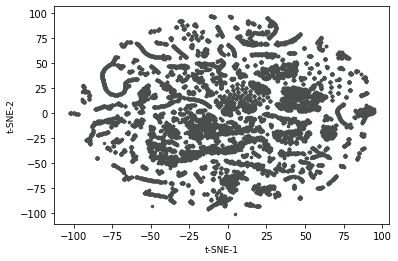

In [ ]:
import bioinfokit
from bioinfokit.visuz import cluster
cluster.tsneplot(score=tsne_em,show=True)

In [ ]:
y_predict = []
y_tests = []

for i in range(Y_pred.shape[0]):
  if(np.argmax(Y_pred[i])==0):
    y_predict.append("DOS")
  elif(np.argmax(Y_pred[i])==1):
    y_predict.append("Normal")
  elif(np.argmax(Y_pred[i])==2):
    y_predict.append("Probe")
  elif(np.argmax(Y_pred[i])==3):
    y_predict.append("R2L")
  elif(np.argmax(Y_pred[i])==4):
    y_predict.append("U2R")


for i in range(Y_test.shape[0]):
    if(np.argmax(Y_test[i])==0):
      y_tests.append("DOS")
    elif(np.argmax(Y_test[i])==1):
      y_tests.append("Normal")
    elif(np.argmax(Y_test[i])==2):
      y_tests.append("Probe")
    elif(np.argmax(Y_test[i])==3):
      y_tests.append("R2L")
    elif(np.argmax(Y_test[i])==4):
      y_tests.append("U2R")

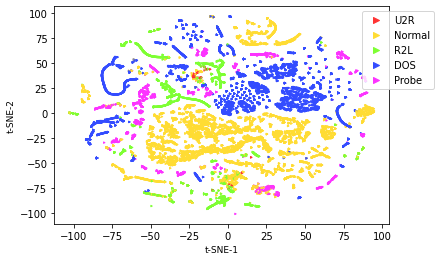

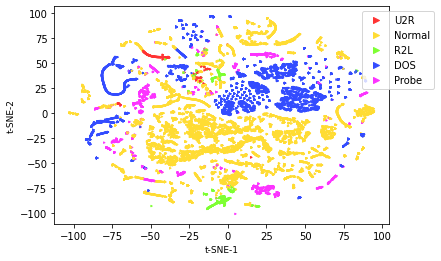

In [ ]:
cluster.tsneplot(score=tsne_em, colorlist=y_tests, legendpos='upper right', colordot=('#FF3333', '#FFDC33', '#7EFF33', '#334CFF', '#FC33FF'), legendanchor=(1.15, 1), show=True, markerdot='>', dotsize=2)
cluster.tsneplot(score=tsne_em, colorlist=y_predict, legendpos='upper right', colordot=('#FF3333', '#FFDC33', '#7EFF33', '#334CFF', '#FC33FF'), legendanchor=(1.15, 1), show=True, markerdot='>', dotsize=2 )

In [ ]:
import imblearn
from imblearn import over_sampling

ada=over_sampling.ADASYN()
X_resampled, Y_resampled = ada.fit_sample(X_train,Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [ ]:
modelnew = Sequential()
modelnew.add(Dense(32, input_shape=(None,116)))
modelnew.add(Activation(activation='relu'))

modelnew.add(Dense(32))
modelnew.add(Activation(activation='relu'))

modelnew.add(Dense(5))
modelnew.add(Activation(activation='softmax'))
modelnew.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
modelnew.fit(X_resampled,Y_resampled,epochs=10,batch_size=3000,validation_data=(X_test,Y_test),verbose=1,callbacks=[callbacks])

Epoch 1/10
113/113 [==============================] - 1s 5ms/step - loss: 1.3896 - accuracy: 0.4805 - val_loss: 0.7192 - val_accuracy: 0.6843
Epoch 2/10
113/113 [==============================] - 0s 4ms/step - loss: 0.4257 - accuracy: 0.8523 - val_loss: 0.7003 - val_accuracy: 0.7893
Epoch 3/10
113/113 [==============================] - 0s 4ms/step - loss: 0.2563 - accuracy: 0.9049 - val_loss: 0.8300 - val_accuracy: 0.8194
Epoch 4/10
113/113 [==============================] - 0s 4ms/step - loss: 0.2087 - accuracy: 0.9185 - val_loss: 0.9583 - val_accuracy: 0.8191
Epoch 5/10
113/113 [==============================] - 0s 4ms/step - loss: 0.1816 - accuracy: 0.9339 - val_loss: 1.1197 - val_accuracy: 0.8111
Epoch 6/10
113/113 [==============================] - 0s 4ms/step - loss: 0.1605 - accuracy: 0.9443 - val_loss: 1.2749 - val_accuracy: 0.8101
Epoch 7/10
113/113 [==============================] - 0s 4ms/step - loss: 0.1451 - accuracy: 0.9500 - val_loss: 1.4254 - val_accuracy: 0.8106
Epoch 

In [ ]:
model_final = tf.keras.models.load_model("/content/drive/MyDrive/Intrusion Detection/0.8302355408668518")

In [ ]:
y_pred = model_final.predict(X_test)

In [ ]:
y_pred.shape

(22543, 5)

In [ ]:
y_predict = []
y_tests = []
for i in range(y_pred.shape[0]):
  y_predict.append(np.argmax(y_pred[i]))

In [ ]:
unique_elements, counts_elements = np.unique(y_predict, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[    0     1     2     3     4]
 [ 7130 10790  2620  1489   514]]


In [ ]:
y_tests=[]
for i in range(Y_test.shape[0]):
  y_tests.append(np.argmax(Y_test[i]))

In [ ]:
unique_elements, counts_elements = np.unique(y_tests, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[   0    1    2    3    4]
 [7459 9711 2421 2885   67]]


In [ ]:
accuracy_score(y_tests,y_predict)

0.8302355498380872

In [ ]:
# confusion matrix
matrix = classification_report(y_tests, y_predict,target_names=["DOS","Normal","Probe","R2L","U2R"])
print(matrix)

              precision    recall  f1-score   support

         DOS       0.95      0.91      0.93      7459
      Normal       0.82      0.91      0.86      9711
       Probe       0.77      0.84      0.80      2421
         R2L       0.70      0.36      0.47      2885
         U2R       0.07      0.55      0.13        67

    accuracy                           0.83     22543
   macro avg       0.66      0.71      0.64     22543
weighted avg       0.84      0.83      0.83     22543



In [ ]:
def split_into_normal_and_attack(y):
  for i,x in enumerate(y):
    if x==1:
      y[i]=1
    else:
      y[i]=0
  return y

In [ ]:
y_test_na = split_into_normal_and_attack(y_tests)
y_pred_na = split_into_normal_and_attack(y_predict)

print(accuracy_score(y_test_na,y_pred_na))

matrix = classification_report(y_test_na, y_pred_na,target_names=["Attack","Normal"])
print(matrix)

0.8767244821008738
              precision    recall  f1-score   support

      Attack       0.93      0.85      0.89     12832
      Normal       0.82      0.91      0.86      9711

    accuracy                           0.88     22543
   macro avg       0.87      0.88      0.88     22543
weighted avg       0.88      0.88      0.88     22543



In [ ]:
y_predict = []
y_tests = []

for i in range(Y_pred.shape[0]):
  if(np.argmax(Y_pred[i])==0):
    y_predict.append("DOS")
  elif(np.argmax(Y_pred[i])==1):
    y_predict.append("Normal")
  elif(np.argmax(Y_pred[i])==2):
    y_predict.append("Probe")
  elif(np.argmax(Y_pred[i])==3):
    y_predict.append("R2L")
  elif(np.argmax(Y_pred[i])==4):
    y_predict.append("U2R")


for i in range(Y_test.shape[0]):
    if(np.argmax(Y_test[i])==0):
      y_tests.append("DOS")
    elif(np.argmax(Y_test[i])==1):
      y_tests.append("Normal")
    elif(np.argmax(Y_test[i])==2):
      y_tests.append("Probe")
    elif(np.argmax(Y_test[i])==3):
      y_tests.append("R2L")
    elif(np.argmax(Y_test[i])==4):
      y_tests.append("U2R")

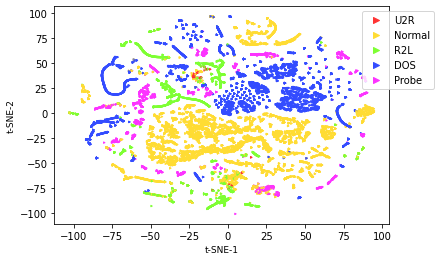

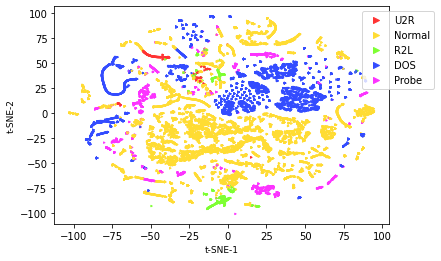

In [ ]:
cluster.tsneplot(score=tsne_em, colorlist=y_tests, legendpos='upper right', colordot=('#FF3333', '#FFDC33', '#7EFF33', '#334CFF', '#FC33FF'), legendanchor=(1.15, 1), show=True, markerdot='>', dotsize=2)
cluster.tsneplot(score=tsne_em, colorlist=y_predict, legendpos='upper right', colordot=('#FF3333', '#FFDC33', '#7EFF33', '#334CFF', '#FC33FF'), legendanchor=(1.15, 1), show=True, markerdot='>', dotsize=2 )

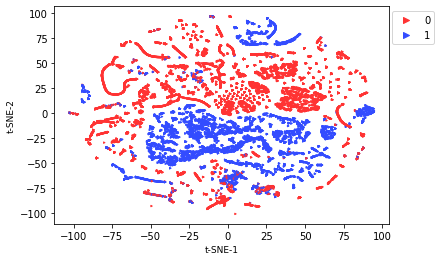

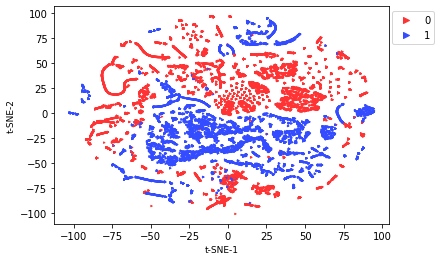

In [ ]:
cluster.tsneplot(score=tsne_em, colorlist=y_test_na, legendpos='upper right', colordot=('#FF3333', '#334CFF'), legendanchor=(1.15, 1), show=True, markerdot='>', dotsize=2)
cluster.tsneplot(score=tsne_em, colorlist=y_pred_na, legendpos='upper right', colordot=('#FF3333', '#334CFF'), legendanchor=(1.15, 1), show=True, markerdot='>', dotsize=2)

In [ ]:
x_train=np.expand_dims(X_train,axis=2)

In [ ]:
x_train.shape

(125972, 116, 1)

In [ ]:
x_test = np.expand_dims(X_test,axis=2)

In [ ]:
x_resampled = np.expand_dims(X_resampled,axis=2)

In [ ]:
modeln = Sequential()
modeln.add(Conv1D(64, (5), input_shape=(116,1), activation='relu'))
modeln.add(MaxPooling1D(2))
modeln.add(Flatten())
modeln.add(Dense(128, activation='relu'))
modeln.add(Dropout(0.5))
modeln.add(Dense(5, activation='softmax'))
print(x)
modeln.compile(optimizer='adam',loss='categorical_crossentropy',metrics =['accuracy'])
modeln.fit(x_resampled,Y_resampled,batch_size=2048,epochs=10,validation_data=(x_test,Y_test),callbacks=[callbacks])

DOS       0
Normal    1
Probe     0
R2L       0
U2R       0
Name: 125971, dtype: uint8
Epoch 1/10
165/165 [==============================] - 32s 17ms/step - loss: 0.6599 - accuracy: 0.7796 - val_loss: 0.8286 - val_accuracy: 0.8383

Reached 83% accuracy!
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Intrusion Detection/0.8382646441459656/assets
Epoch 2/10
165/165 [==============================] - 2s 12ms/step - loss: 0.2235 - accuracy: 0.9197 - val_loss: 1.1312 - val_accuracy: 0.8317

Reached 83% accuracy!
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Intrusion Detection/0.8316994309425354/assets
Epoch 3/10
165/165 [==============================] - 2s 12ms/step - loss: 0.1536 - accuracy: 0.9451 - val_loss: 1.3842 - val_accuracy: 0.8228
Epoch 4/10
165/165 [==============================] - 2s 13ms/step - loss: 0.1245 - accuracy: 0.9557 - val_loss: 1.6394 - val_accuracy: 0.8165
Epoch 5/10
165/165 [==============================] - 2s 12ms/step - loss: 0.1059 - ac

In [ ]:
modeln = keras.models.load_model("/content/drive/MyDrive/Intrusion Detection/0.8426562547683716")

In [ ]:
y_pred = modeln.predict(x_test)
y_predict = []
y_tests = []
for i in range(y_pred.shape[0]):
  y_predict.append(np.argmax(y_pred[i]))

for i in range(Y_test.shape[0]):
  y_tests.append(np.argmax(Y_test[i]))

print(accuracy_score(y_tests,y_predict))

# confusion matrix
matrix = classification_report(y_tests, y_predict,target_names=["DOS","Normal","Probe","R2L","U2R"])
print(matrix)

0.8426562569311982
              precision    recall  f1-score   support

         DOS       0.97      0.89      0.92      7459
      Normal       0.82      0.94      0.88      9711
       Probe       0.76      0.92      0.83      2421
         R2L       0.90      0.34      0.49      2885
         U2R       0.06      0.43      0.10        67

    accuracy                           0.84     22543
   macro avg       0.70      0.70      0.64     22543
weighted avg       0.87      0.84      0.84     22543



In [ ]:
y_test_na = split_into_normal_and_attack(y_tests)
y_pred_na = split_into_normal_and_attack(y_predict)

print(accuracy_score(y_test_na,y_pred_na))

matrix = classification_report(y_test_na, y_pred_na,target_names=["Attack","Normal"])
print(matrix)

0.8853302577296722
              precision    recall  f1-score   support

      Attack       0.95      0.84      0.89     12832
      Normal       0.82      0.94      0.88      9711

    accuracy                           0.89     22543
   macro avg       0.88      0.89      0.88     22543
weighted avg       0.89      0.89      0.89     22543



In [ ]:
y_predict = []
y_tests = []

for i in range(Y_pred.shape[0]):
  if(np.argmax(Y_pred[i])==0):
    y_predict.append("DOS")
  elif(np.argmax(Y_pred[i])==1):
    y_predict.append("Normal")
  elif(np.argmax(Y_pred[i])==2):
    y_predict.append("Probe")
  elif(np.argmax(Y_pred[i])==3):
    y_predict.append("R2L")
  elif(np.argmax(Y_pred[i])==4):
    y_predict.append("U2R")


for i in range(Y_test.shape[0]):
    if(np.argmax(Y_test[i])==0):
      y_tests.append("DOS")
    elif(np.argmax(Y_test[i])==1):
      y_tests.append("Normal")
    elif(np.argmax(Y_test[i])==2):
      y_tests.append("Probe")
    elif(np.argmax(Y_test[i])==3):
      y_tests.append("R2L")
    elif(np.argmax(Y_test[i])==4):
      y_tests.append("U2R")

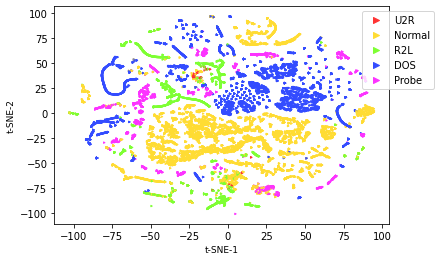

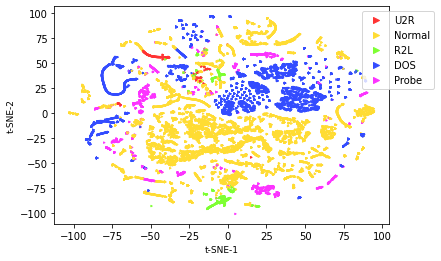

In [ ]:
cluster.tsneplot(score=tsne_em, colorlist=y_tests, legendpos='upper right', colordot=('#FF3333', '#FFDC33', '#7EFF33', '#334CFF', '#FC33FF'), legendanchor=(1.15, 1), show=True, markerdot='>', dotsize=2)
cluster.tsneplot(score=tsne_em, colorlist=y_predict, legendpos='upper right', colordot=('#FF3333', '#FFDC33', '#7EFF33', '#334CFF', '#FC33FF'), legendanchor=(1.15, 1), show=True, markerdot='>', dotsize=2 )

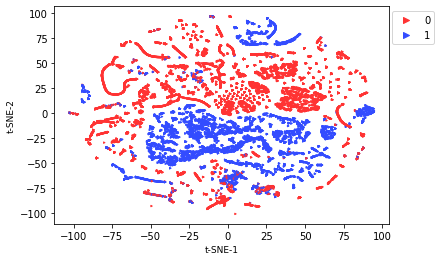

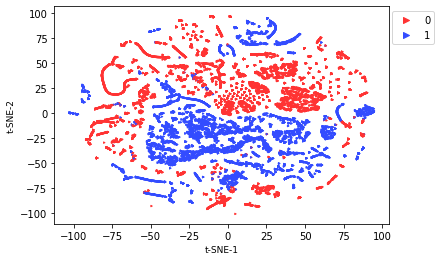

In [ ]:
cluster.tsneplot(score=tsne_em, colorlist=y_test_na, legendpos='upper right', colordot=('#FF3333', '#334CFF'), legendanchor=(1.15, 1), show=True, markerdot='>', dotsize=2)
cluster.tsneplot(score=tsne_em, colorlist=y_pred_na, legendpos='upper right', colordot=('#FF3333', '#334CFF'), legendanchor=(1.15, 1), show=True, markerdot='>', dotsize=2)